In [3]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from dataset import create_datasets
from model import Net
from anchor import generate_anchors, mark_anchors
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import sleep

## 创建Datasets && 随机看一些图片和真值

In [4]:
train_dataset, val_dataset = create_datasets('/home/louis/datasets/wider_face')
# TODO: show some images and ground truth bbox here

In [5]:
error_index = 1769

[[  84.15224913  126.25        307.8200692   220.        ]
 [  66.43598616  231.25        294.53287197  306.25      ]]


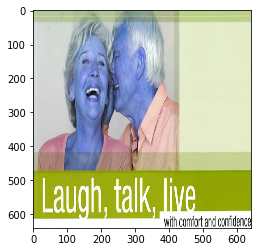

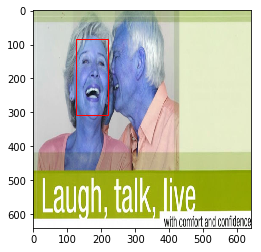

In [11]:
plt.imshow(train_dataset[error_index][0])

def show_anchor(image, anchor):
    fig, ax = plt.subplots(1)
    rect = patches.Rectangle((anchor[1], anchor[0]), anchor[3] - anchor[1], anchor[2] - anchor[0] ,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.imshow(image)
    
image, annotation, path = train_dataset[error_index]

print(annotation)
show_anchor(image, annotation[0])

50


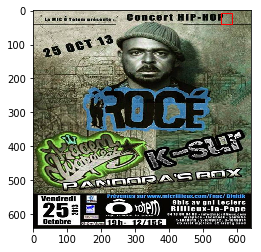

In [30]:
image = cv2.imread('/home/louis/datasets/wider_face/WIDER_train/images/18--Concerts/18_Concerts_Concerts_18_585.jpg')
image = cv2.resize(image, (640, 640))
posr_anchors = np.array([[ 96, 272, 160, 336],
       [ 96, 288, 160, 352],
       [ 96, 304, 160, 368],
       [ 96, 320, 160, 384],
       [ 96, 336, 160, 400],
       [ 96, 352, 160, 416],
       [112, 272, 176, 336],
       [112, 304, 176, 368],
       [112, 320, 176, 384],
       [112, 336, 176, 400],
       [112, 352, 176, 416],
       [128, 272, 192, 336],
       [128, 288, 192, 352],
       [128, 304, 192, 368],
       [128, 320, 192, 384],
       [128, 336, 192, 400],
       [128, 352, 192, 416],
       [144, 272, 208, 336],
       [144, 288, 208, 352],
       [144, 304, 208, 368],
       [144, 320, 208, 384],
       [144, 336, 208, 400],
       [144, 352, 208, 416],
       [ 32, 224, 160, 352],
       [ 32, 256, 160, 384],
       [ 32, 288, 160, 416],
       [ 32, 320, 160, 448],
       [ 64, 192, 192, 320],
       [ 64, 224, 192, 352],
       [ 64, 256, 192, 384],
       [ 64, 288, 192, 416],
       [ 64, 320, 192, 448],
       [ 64, 352, 192, 480],
       [ 96, 192, 224, 320],
       [ 96, 224, 224, 352],
       [ 96, 256, 224, 384],
       [ 96, 288, 224, 416],
       [ 96, 320, 224, 448],
       [ 96, 352, 224, 480],
       [128, 224, 256, 352],
       [128, 256, 256, 384],
       [128, 288, 256, 416],
       [128, 320, 256, 448],
       [160, 288, 288, 416],
       [  0, 128, 256, 384],
       [  0, 192, 256, 448],
       [  0, 256, 256, 512],
       [ 64, 128, 320, 384],
       [ 64, 192, 320, 448],
       [ 64, 256, 320, 512]])


print(len(posr_anchors))





show_anchor(image,[  8, 552,  40, 584])

## 创建模型并随机用某张图片正向获得Predictions

In [41]:
image, annotation, path = train_dataset[error_index]
height, width = image.shape[:2]
image = cv2.resize(image, (640, 640))

height_scale = 640.0 / height
width_scale, height_scale = 640.0 / width, 640.0 / height

In [11]:
_input = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
net = Net()
predictions = list(net(_input))

In [12]:
print(len(predictions))

6


In [13]:
for index, prediction in enumerate(predictions):
    predictions[index] = prediction.view(1, 6, -1) # 1 should be replaced by batch size

### 每个feature map的预测数量

In [14]:
prediction_count = list(map(lambda x: x.size()[2], predictions))
print("predictions(4 + 2) of every feature map(from bottom to up) is {}".format( list(prediction_count) ) )

predictions(4 + 2) of every feature map(from bottom to up) is [25600, 6400, 1600, 400, 100, 25]


## 生成的Anchor

In [15]:
anchors = generate_anchors() # 使用默认设置

In [16]:
def show_anchor(image, anchor):
    fig, ax = plt.subplots(1)
    rect = patches.Rectangle((anchor[1], anchor[0]), anchor[3] - anchor[1], anchor[2] - anchor[0] ,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.imshow(image)


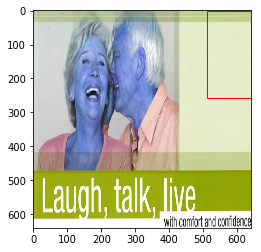

In [18]:
for index, anchor in enumerate(anchors[4]):
    #left top width height
    if index == 8:
        show_anchor(image, anchor)
        break

### 把predictions和anchor转换成二维矩阵   ( batch_size x anchor_size x 6 or 4)

In [19]:
predictions_concated = torch.cat(predictions, dim=2).permute(0, 2, 1)
print(predictions_concated.size())

torch.Size([1, 34125, 6])


In [20]:
anchors = np.vstack(list(map(lambda x: np.array(x), anchors)))
print(anchors.shape)

(34125, 4)


### 使用Ground Truth来标记Anchor


In [62]:
gt_bboxes_scaled = list(map(lambda x: [  x[0] * height_scale, x[1] * width_scale, x[2] * height_scale, x[3] * width_scale ] , annotation))
gt_bboxes_scaled = np.array(gt_bboxes_scaled)
positive_anchor_indices, matched_gt_box_indices, negative_anchor_indices = mark_anchors(anchors, gt_bboxes_scaled)

print(positive_anchor_indices)
print(matched_gt_box_indices)
print(negative_anchor_indices)


import numpy as np
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(4, 40), dpi=120)
# columns = 4
# rows = 40
# for i in range(1, columns*rows +1):
#   if i >= 150:
#        break
#    ax = fig.add_subplot(rows, columns, i)
#    anchor = anchors[positive_anchor_indices[i]]
#    print(anchor)
#    rect = patches.Rectangle((anchor[1], anchor[0]), anchor[3] - anchor[1], anchor[2] - anchor[0] ,linewidth=1,edgecolor='r',facecolor='none')
#    ax.add_patch(rect)
#    ax.imshow(image)
#plt.show()

[32135 32174 32175 32176 32208 32209 32210 32214 32215 32216 32247 32248
 32249 32250 32254 32255 32256 32287 32288 32289 32290 32294 32295 32296
 32327 32328 32329 32330 32334 32335 32336 32367 32368 32369 32370 32374
 32375 32376 32407 32408 32409 32410 32414 32415 32416 32447 32448 32449
 32450 32454 32455 32456 32487 32488 32489 32490 32494 32495 32496 32527
 32528 32529 32530 32534 32535 32536 32567 32568 32569 32570 32574 32575
 32576 32607 32608 32609 32610 32614 32615 32616 32648 32649 32650 33606
 33607 33622 33623 33624 33625 33626 33627 33628 33642 33643 33644 33645
 33646 33647 33648 33662 33663 33664 33665 33666 33667 33668 33682 33683
 33684 33685 33686 33687 33688 33702 33703 33704 33705 33706 33707 33708
 33722 33723 33724 33725 33726 33727 33728 33742 33743 33744 33745 33746
 33747 33763 33764 34000 34001 34002 34003 34010 34011 34012 34013 34014
 34020 34021 34022 34023 34030 34031]
[1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1
 1 0 0 0 0 

## 一些结论

* 如果anchor不做scale，诸如一些脸比较长的图片的图片很难有positive anchor，设置到0.5都一个都没有，一个优化点是每个anchor再加上一个纵向的2倍 anchor。

In [36]:
total = 0
for i in range(500):
    test_image, annotation, path = train_dataset[i]
    gt_bboxes_scaled = list(map(lambda x: [  x[0] * height_scale, x[1] * width_scale, x[2] * height_scale, x[3] * width_scale ] , annotation))
    gt_bboxes_scaled = np.array(gt_bboxes_scaled)
    positive_anchor_indices, matched_gt_box_indices, negative_anchor_indices = mark_anchors(anchors, gt_bboxes_scaled)
    print(len(matched_gt_box_indices))
    total += len(matched_gt_box_indices)
print(total)


9
13
105
106
162
51
533
417
326
151
87
113
232
46
187
162
191
219
1064
30
2
119
93
24
279
279
440
29
34
36
674
45
225
52
9
32
20
162
457
206
210
424
11
8
204
111
12
26
332
333
106
59
8
89
123
120
170
39
277
44
39
92
192
19
180
0
58
63
443
15
67
123
341
442
70
126
224
10
331
78
107
41
11
178
39
321
71
16
3
78
879
352
5
84
277
148
119
175
36
102
25
66
14
172
64
886
115
166
76
0
97
120
205
85
19
57
55
169
35
32
16
101
81
11
196
255
90
61
114
104
372
505
109
154
29
531
168
7
74
261
41
41
24
56
74
64
85
173
71
448
629
16
51
94
281
104
104
84
123
60
260
476
18
114
46
122
464
6
78
15
190
52
113
95
14
96
61
230
4
820
148
57
78
363
4
58
125
114
105
18
120
52
0
264
127
127
121
132
85
14
109
9
27
168
18
18
48
53
86
54
103
95
53
77
754
270
1050
219
173
73
159
44
14
21
10
214
287
0
409
7
33
266
142
66
32
1060
66
63
963
181
15
72
33
103
293
99
89
65
15
29
37
124
191
264
184
60
16
93
249
75
54
51
46
173
332
51
34
50
9
18
71
115
75
205
75
180
13
98
12
0
122
245
191
195
39
141
27
56
255
68
49
50
9
127


## 计算Loss

针对每一个Anchor，我们有一个大小为6的预测向量（position delta + score），现在我们又根据真值标记出了正Anchor和负Anchor，以及每个正Anchor所对应的真值bbox，则可以进行Loss的计算了。

这里有两个loss，回归（Smooth L1 loss）和分类（cross entropy loss）

### 回归Loss，参考Faster RCNN 公式2

In [10]:
# 预测bbox 和 真值bbox 同时对 Anchor 计算 t 和 t'  ， loss = L1 loss of  t and t'， 注意 x y对应的是center，而不是left top
def change_coordinate(coordinates):
    """change top left bottom right to center x center y, width, height"""
    width = (coordinates[:, 3] - coordinates[:, 1])[:, np.newaxis]
    height = (coordinates[: ,2] - coordinates[: ,0])[:, np.newaxis]
    center_x = ((coordinates[: ,3] + coordinates[:, 1]) / 2)[:, np.newaxis]
    center_y = ((coordinates[:, 2] + coordinates[: ,0]) / 2)[:, np.newaxis]
    return np.concatenate( [center_x, center_y, width, height] , axis=1  )

In [11]:
# 选出参与计算回归Loss的Anchor和predictions，包括对应的ground truth
anchors_positive = torch.tensor(change_coordinate(anchors[positive_anchor_indices])).float() / 640
matched_bboxes = torch.tensor(change_coordinate(gt_bboxes_scaled[matched_gt_box_indices])).float() / 640
positive_predictions = torch.squeeze(predictions_concated)[positive_anchor_indices][:, :4]

epsilon = 0.0001
# 计算RPN公式5的8个变量
tx = positive_predictions[:, 0] - anchors_positive[:, 0]
ty = positive_predictions[:, 1] - anchors_positive[:, 1]
tw = torch.log( (positive_predictions[:, 2] + epsilon) / anchors_positive[:, 2])
th = torch.log( (positive_predictions[:, 3] + epsilon) / anchors_positive[:, 3])
t = torch.stack( (tx, ty, tw, th) )

gtx = matched_bboxes[:, 0] - anchors_positive[:, 0]
gty = matched_bboxes[:, 1] - anchors_positive[:, 1]
gtw = torch.log(matched_bboxes[:, 2] / anchors_positive[:, 2])
gth = torch.log(matched_bboxes[:, 3] / anchors_positive[:, 3])
gt = torch.stack( (gtx, gty, gtw, gth) )

In [12]:
F.smooth_l1_loss(t, gt)

tensor(2.5198)

In [27]:
# 选出所有被标记为正/负的anchor，以及对应的predictions
positive_predictions = torch.squeeze(predictions_concated)[positive_anchor_indices][:, 4:]
negative_predictions = torch.squeeze(predictions_concated)[negative_anchor_indices][:, 4:]

In [46]:
positive_target = torch.zeros_like( positive_predictions )
positive_target[:, 1] = 1.0
negative_target = torch.zeros_like(  negative_predictions )
negative_target[:, 0] = 1.0


effective_predictions = torch.cat( (positive_predictions, negative_predictions))
targets = torch.cat( (positive_target, negative_target) )

shuffle_indexes = torch.randperm(effective_predictions.size()[0])
effective_predictions = effective_predictions[shuffle_indexes]
targets = targets[shuffle_indexes]


In [47]:
F.binary_cross_entropy(F.sigmoid(effective_predictions), targets)

tensor(0.7147)